In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
print(os.getcwd())
print(os.listdir())
import logging
import numpy as np
import matplotlib.pyplot as plt
import copy
import gc
import time
import ot as pot
from torch import nn, autograd,Tensor
from torch.utils.data import TensorDataset, DataLoader
from typing import Optional, Tuple, Dict
from torch.distributions import Categorical, MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from lib.hjbflow import ICNN1, ICNN2,ICNN3, evaluation_straight, evaluation,sample_ode_hj,train_flow2d,ICNN, transform
from tqdm import tqdm
from lib.loss_func import compute_loss,compute_loss_back
from lib.act_func import Activations
#from lib.train_flow import train_flow

/home/sfh/ICNNFlow-new
['toy_test-Copy5.ipynb', 'train_hdbm-Copy2.ipynb', 'train_hdbm-0623.ipynb', 'train_hdbm-Copy6.ipynb', '__pycache__', 'lib', '.ipynb_checkpoints', 'results', 'toy_test-Copy2.ipynb', 'ofm_transfer_mb128.png', 'test_ALAE.ipynb', '8gaussiantest.ipynb', 'src', 'toy_test-Copy3.ipynb', 'notebooks_utils.py', 'toy_test-Copy4.ipynb', 'c-reflow_benchmark.ipynb', 'backup', 'train_hdbm-idp.ipynb', 'toy_test.ipynb', '.gitignore', 'creflow_bm.ipynb', 'data', 'infer_icnn_flow.py', 'train_hdbm-Copy4.ipynb', 'icnn_flow.py', 'reflow_benchmark-Copy1.ipynb', 'reflow_benchmark.ipynb', 'ALAE', 'W2_images.ipynb', 'train_ALAE.ipynb', 'ofmsrc', 'train_hdbm-Copy5.ipynb', '8gaussiantest-Copy1.ipynb', 'toy_test-Copy1.ipynb', 'train_mnist.ipynb', 'ALAE_AC.ipynb', 'notebook', 'generators2d.py', 'datasets', 'benchmarks', 'train_hdbm.ipynb', 'reflow_benchmark-Copy2.ipynb', 'largetest.ipynb']


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
log_dir = "./results/8g/"
os.makedirs(log_dir, exist_ok=True)
output_dir = log_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
torch.manual_seed('0')

#Gaussian mixture models
D = 5. # diameter of mixtures
M = D + 5 # range
VAR = 0.15 # variance
num_samples = 10000
iterations = 25000
batch_size = 1024
lr =1e-2
test_size = 1000
# network setup
act_fn =Activations.get_act('ssp')
num_layers =6
loss_func=compute_loss,
dimh =1024
dim = 2
lambda_hj = 1
eps  = 1e-4
# model setup
hyperparams = {
    "iterations": iterations,
    "batch_size": batch_size,
    "learning_rate": lr,
    "num_hidden_layers": num_layers,
    "dimh": dimh,
    "act_fn": Activations.get_act('ssp')
}
logging.info("parameters: %s", hyperparams)

# Source and Target distributions

Samples shape: torch.Size([10000, 2]) torch.Size([10000, 2])


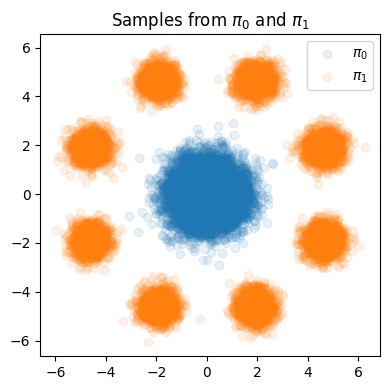

In [5]:
COMP =8

shift = torch.pi/COMP
theta = np.linspace(0.,2*np.pi,COMP,endpoint=False)
theta = torch.Tensor(theta)
pos0 = D*torch.stack((torch.cos(theta),torch.sin(theta))).t()
pos1 = D*torch.stack((torch.cos(theta+shift),torch.sin(theta+shift))).t()
varsmat =VAR * torch.stack([torch.eye(2) for _ in range(COMP)])

initial_mix = Categorical(torch.tensor([1.0]))
initial_comp = MultivariateNormal(torch.tensor([[0,0]]),torch.eye(2))
initial_model = torch.distributions.multivariate_normal.MultivariateNormal(torch.tensor([0.,0.]),0.5*torch.eye(2).float())

             
target_mix = Categorical(torch.tensor([1/COMP for _ in range(COMP)]))
target_comp = MultivariateNormal(pos1.float(),varsmat)
target_model = MixtureSameFamily(target_mix, target_comp)


# initial samples
x0_train = initial_model.sample([num_samples]).to(device)
x1_train = target_model.sample([num_samples]).to(device)
print('Samples shape:', x0_train.shape, x1_train.shape)

plt.figure(figsize=(4, 4)); plt.title(r'Samples from $\pi_0$ and $\pi_1$'); 
plt.scatter(x0_train[:, 0].cpu(), x0_train[:, 1].cpu(), alpha=0.1, label=r'$\pi_0$'); 
plt.scatter(x1_train[:, 0].cpu(), x1_train[:, 1].cpu(), alpha=0.1, label=r'$\pi_1$'); 
plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(output_dir, "samples.png"))

Train model

In [6]:
model =ICNN3(dim=dim, dim_t=1, dimh=dimh, num_hidden_layers=num_layers,act_fn=act_fn, batch_size=batch_size,eps=eps).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [7]:
# # pretrain;optimal
# dataset = TensorDataset(x0_train)              # x0_train=[num_samples,2]
# loader  = DataLoader(dataset, batch_size=1024, shuffle=True)
# def train_identity_map(D, sampler, batch_size=1024, max_iter=5000, lr=1e-3, tol=1e-3, blow=3,  device= device):
    
#     opt = torch.optim.Adam(D.parameters(), lr=lr, weight_decay=1e-10)
#     print('Training the potentials to satisfy push(x)=x')
#     data_iter = iter(loader)
#     pbar = tqdm(range(max_iter))
#     for iteration in pbar:
#         try:
#             X_batch = next(data_iter)[0]           # DataLoader 返回 (tensor,)
#         except StopIteration:
#             data_iter = iter(loader)
#             X_batch = next(data_iter)[0]
        
#         X = X_batch.to(device)                   # [batch_size, ...]
#         t = torch.rand(X.size(0), 1, device=device)
#         with torch.no_grad():
#             X *= blow
#         X.requires_grad_(True)

#         loss = F.mse_loss(D.gradx(X,t), X.detach())
#         #loss = F.mse_loss(torch.sum(D(X,t),dim=1), torch.sum(X.pow(2)/2.0,dim=1).detach())
#         loss.backward()
#         opt.step(); opt.zero_grad()
#         pbar.set_description(f" loss {loss:.4f}")

#         if loss.item() < tol:
#             break
            
#     loss = loss.item()
#     torch.cuda.empty_cache()
#     return loss

# pretrain_sampler = x0_train
# train_identity_map(model, pretrain_sampler, blow=3,device = device)


from iter 25000 continue to train，loss_history length 25000
finish training


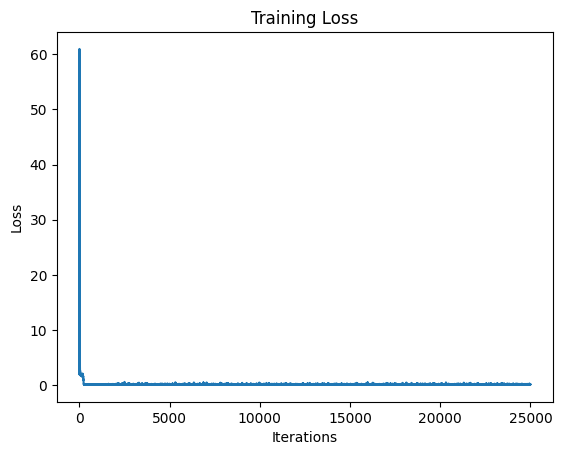

In [17]:
loss_history = []
chunk = 5000            
os.makedirs(log_dir, exist_ok=True)
checkpoint_path = os.path.join(log_dir, f"checkpoint_back.pth")


start_iter = 0
loss_history = []
if os.path.exists(checkpoint_path):
    ck = torch.load(checkpoint_path,weights_only=False, map_location=device)
    model.load_state_dict(ck['model_state'])
    optimizer.load_state_dict(ck['optimizer_state'])
    start_iter = ck.get('iteration', 0) + 1
    loss_history = ck.get('loss_history', [])
    print(f"from iter {start_iter} continue to train，loss_history length {len(loss_history)}")
else:
    print("Begin Training")

current_iter = start_iter

try:
    while current_iter < iterations:
        this_chunk = min(chunk, iterations - current_iter)
        print(f"Trained iter {current_iter} to {current_iter + this_chunk - 1}")
        loss_seg = train_flow2d(
            model, optimizer,
            x0_train, x1_train,
            iterations=this_chunk,
            batch_size=batch_size,
            loss_func=compute_loss_back,
            minibatch=True,
        )
        
        loss_history.extend(loss_seg)
        current_iter += this_chunk

        # save checkpoint
        torch.save({
            'iteration': current_iter - 1,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'loss_history': loss_history,
            'hyperparams': {
                'dim': dim,
                'num_hidden_layers': num_layers,
                'dimh': dimh,
                'activation': act_fn,
                'batch_size': batch_size,
                'lr': lr,
            },
            'model_name': model.__class__.__name__,
            'model_structure': str(model),
        }, checkpoint_path)
        print(f"save checkpoint to iter {current_iter - 1}")
    print("finish training")
except KeyboardInterrupt:
    torch.save({
        'iteration': current_iter - 1,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'loss_history': loss_history,
    }, checkpoint_path)
    print(f"save checkpoint to iter {current_iter - 1}")
    raise

# optimizer   = torch.optim.Adam(model.parameters(), lr=lr)
# loss_history = train_flow2d(model, optimizer, x0_train, x1_train, iterations, batch_size,loss_func=compute_loss_back,minibatch=True)

plt.figure()
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig(os.path.join(output_dir, "loss_3.png"))
plt.show()

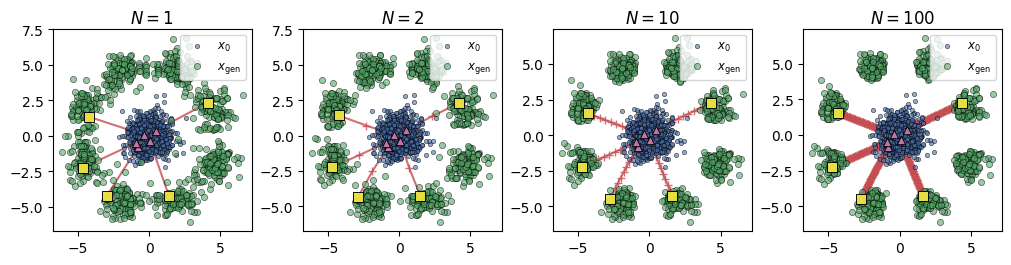

In [18]:
test_size=1000
# _=evaluation(model,x0_train[:test_size,:],x1_train[:test_size,:],N=[1,2,10,100],plot_traj=False)
_=evaluation(model,x0_train[:test_size,:],x1_train[:test_size,:],N=[1,2,10,100],plot_traj=True,pad_ratio=0.05,num_paths=5)
plt.savefig(os.path.join(output_dir, "evaluation_results.png"))

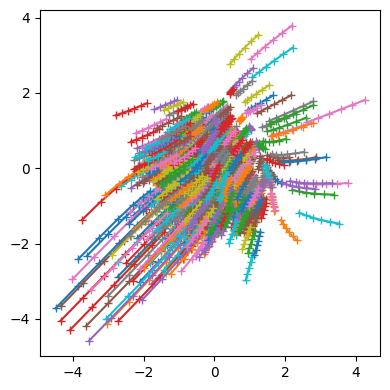

In [10]:
test_size=1000
nt = 5
dt = 1.0/nt
x_t = x0_train[:test_size,:]
x_rec = []
x_rec.append(x_t.cpu().numpy())
for i in range(nt):
    
    t = torch.ones((test_size,1)).to(device)*i*dt
    
    x_t.requires_grad_(True) 
    gradpsi=model.gradx(x_t,t)
    
    v = (gradpsi-x_t)/(1-t)
    #v=(x_t-gradpsi)/t
    x_t = x_t +dt*v
    x_t = x_t.detach()
    x_rec.append(x_t.cpu().numpy())

    
x_rec = np.array(x_rec)
plt.figure(figsize=(4, 4))
for i in range(test_size):
    plt.plot(x_rec[:,i,0],x_rec[:,i,1],'+-')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "pathcheck_newre_3.png"))

In [11]:
# test_size=100
# norm_rec = [] 
# res_rec=[]
# nt=100
# for i in range(nt):
#     t = torch.ones((test_size,1)).to(device)*i/nt
#     x_t = x_t.to(device)
#     x_t = (1-t)*x0_train[:test_size,:]+t*x1_train[:test_size,:]
    
#     t.requires_grad_(True)
#     x_t.requires_grad_(True)
#     psi_val = model(x_t,t)
#     psi_grad = model.gradx(x_t,t)
#     psi_dt = model.gradt(x_t,t)    
#     #v =(psi_grad-x_t)/(1-t)
#     v=(x_t-psi_grad)/t
#     res=psi_dt+(psi_val - torch.sum(torch.square(x_t),dim=1) / 2.0 + torch.sum(torch.square(psi_grad-x_t),dim=1) / 2.0)/(1.0-t)
#     res = res *(1.0-t)
#     norm_rec.append(torch.norm(v).detach().cpu().numpy())
#     res_rec.append(torch.norm(res).detach().cpu().numpy())
# plt.plot(np.linspace(0,1,nt,endpoint=False),np.array(res_rec)/test_size)

In [12]:
x = torch.linspace(4,6,20)
y = torch.linspace(4,6,20)
xx,yy = torch.meshgrid(x,y)
inputx = torch.stack((xx.reshape(-1),yy.reshape(-1)),dim = 1)[8::20,:]
inputx.requires_grad_(True)
inputt = 0 + torch.zeros([inputx.size()[0],1])
# val=Psi.gradx(inputx.to('cuda'),inputt.to('cuda'))
val=model(inputx.to(device),inputt.to(device))

/home/sfh/anaconda3/envs/ofmenv/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647327249/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


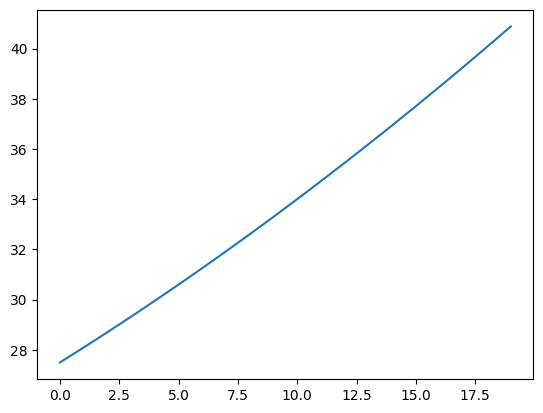

In [13]:
plt.plot(val.detach().cpu().numpy())

In [14]:
import ot as pot
batchsize = 64
x0 = x0_train[:batchsize]
x1 = x1_train[:batchsize]
M = (torch.cdist(x0,x1)**2).detach().cpu().numpy()
gamma = pot.emd(np.ones((batchsize,)),np.ones((batchsize,)),M)
x1ind = np.argmax(gamma,axis = 1)
x1 = x1[x1ind].detach().cpu().numpy()
x0 = x0.detach().cpu().numpy()

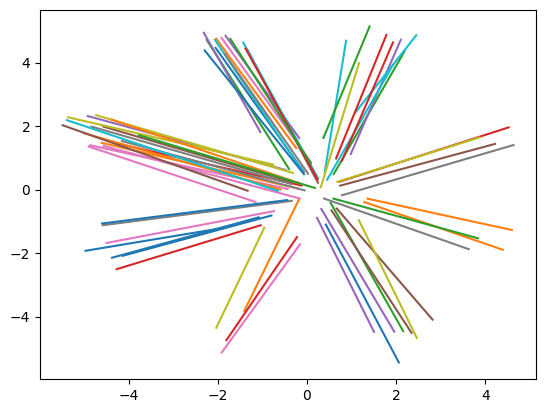

In [15]:
plt.figure()
for i in range(batchsize):
    plt.plot([x0[i,0],x1[i,0]],[x0[i,1],x1[i,1]])

In [16]:
#save config
config_path = os.path.join(log_dir, "train_config_back.txt")
with open(config_path, "w") as f:
    f.write("Training configuration:\n")
    f.write(f"Device: {device}\n")
    f.write(f"Num samples: {num_samples}\n")
    f.write(f"Iterations: {iterations}\n")
    f.write(f"Batch size: {batch_size}\n")
    f.write(f"dim: {dim}\n")
    f.write(f"Learning rate: {lr}\n")
    f.write(f"Hidden layers: {num_layers}\n")
    f.write(f"Hidden dim: {dimh}\n")
    f.write(f"loss_func: {loss_func}\n")
    f.write(f"lambda_hj: {lambda_hj}\n")
    f.write(f"Activation function: {act_fn}\n")
logging.info(f"Saved training config to {config_path}")